In [2]:
import pickle
import numpy as np
import torch

In [3]:
import matplotlib.pyplot as plt

In [3]:
with open('CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,0.00,1)_L(8,10,2)_xj(0)_seed0_64_wf.pickle','rb') as f:
    wf = pickle.load(f)

In [4]:
with open('CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,0.00,1)_L(8,10,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wf2 = pickle.load(f)

In [5]:
with open('CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,0.00,1)_L(12,14,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wf3 = pickle.load(f)

In [6]:
with open('CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,0.00,1)_L(14,16,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wf4 = pickle.load(f)

In [7]:
with open('CT_En2000_pctrl(0.50,0.50,1)_pproj(0.00,0.00,1)_L(16,18,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wf5 = pickle.load(f)

In [22]:
with open('CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,1.00,21)_L(8,10,2)_xj(0)_seed0_64_wf.pickle','rb') as f:
    wfs_0_8 = pickle.load(f)
with open('CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,1.00,21)_L(12,14,2)_xj(0)_seed0_64_wf.pickle','rb') as f:
    wfs_0_12 = pickle.load(f)

In [ ]:
with open('CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,1.00,21)_L(8,10,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wfs_1_3_8 = pickle.load(f)
with open('CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,1.00,21)_L(10,12,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wfs_1_3_10 = pickle.load(f)
with open('CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,1.00,21)_L(12,14,2)_xj(1-3,2-3)_seed0_64_wf.pickle','rb') as f:
    wfs_1_3_12 = pickle.load(f)

In [141]:
def convert_tensor(wf,grid=21,kmax=-1):
    wf=torch.stack(wf)
    wf=wf.reshape((grid,grid)+wf.shape[1:])
    wf=torch.mean(torch.abs(wf[...,:kmax,:])**2,axis=(-2,-1)).reshape((grid,grid,-1))
    return wf
    

In [23]:
wfs_0_8_dist=convert_tensor(wfs_0_8)
wfs_0_12_dist=convert_tensor(wfs_0_12)

In [152]:
wfs_0_12_dist_half=convert_tensor(wfs_0_12,kmax=1000)
wfs_0_12_dist_quarter=convert_tensor(wfs_0_12,kmax=500)

In [9]:
wfs_1_3_8_dist=convert_tensor(wfs_1_3_8)
wfs_1_3_10_dist=convert_tensor(wfs_1_3_10)
wfs_1_3_12_dist=convert_tensor(wfs_1_3_12)

In [14]:
wfs_0_tensor=torch.stack(wfs_0)

In [15]:
wfs_tensor=torch.stack(wfs)

In [16]:
torch.where(torch.isnan(wfs_0_tensor))

(tensor([216, 216, 216,  ..., 373, 373, 373]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0, 0, 1,  ..., 0, 1, 1]),
 tensor([0, 1, 0,  ..., 1, 0, 1]),
 tensor([1642, 1642, 1642,  ...,  980,  980,  980]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [17]:
230//21,230%21

(10, 20)

In [18]:
wfs_all=wfs_tensor.reshape((21,21)+wfs_tensor.shape[1:])

In [19]:
wfs_0_all=wfs_0_tensor.reshape((21,21)+wfs_0_tensor.shape[1:])

In [20]:
dist=(torch.abs(wf[0])**2).mean(axis=(-2,-1)).flatten()

In [21]:
dist2=(torch.abs(wf2[0])**2).mean(axis=(-2,-1)).flatten()

In [22]:
dist3=(torch.abs(wf3[0])**2).mean(axis=(-2,-1)).flatten()

In [23]:
dist4=(torch.abs(wf4[0])**2).mean(axis=(-2,-1)).flatten()

In [24]:
dist5=(torch.abs(wf5[0])**2).mean(axis=(-2,-1)).flatten()

In [25]:
wfs_all.shape

torch.Size([21, 21, 2, 2, 2, 2, 2, 2, 2, 2, 2000, 1])

In [26]:
wfs_dist=torch.mean(torch.abs(wfs_all)**2,axis=(-2,-1)).reshape((21,21,-1))

In [27]:
wfs_0_dist=torch.mean(torch.abs(wfs_0_all)**2,axis=(-2,-1)).reshape((21,21,-1))

In [28]:
plt.pcolormesh(np.linspace(0,1,21),np.linspace(0,1,21),wfs_dist[:,:,256//3])
plt.colorbar()

NameError: name 'plt' is not defined

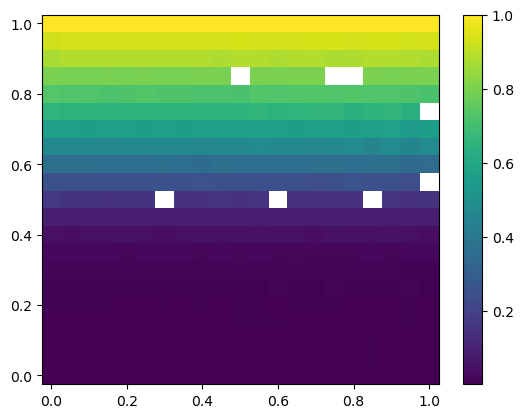

In [30]:
plt.pcolormesh(np.linspace(0,1,21),np.linspace(0,1,21),wfs_0_dist[:,:,0])
plt.colorbar()

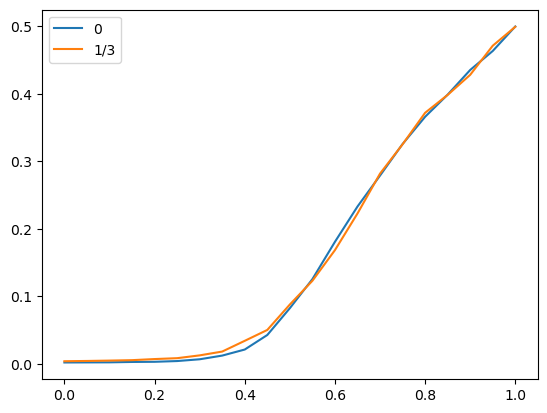

In [31]:
plt.plot(np.linspace(0,1,21),wfs_0_dist[:,0,0]/2,label='0')
plt.plot(np.linspace(0,1,21),wfs_dist[:,0,256//3],label='1/3')
plt.legend()

In [ ]:
wfs_dist[:,:,256//3]

In [33]:
wfs_dist.shape

torch.Size([21, 21, 256])

In [39]:
2**(-wfs_dist.shape[-1])

8.636168555094445e-78

(0.0, 1.1)

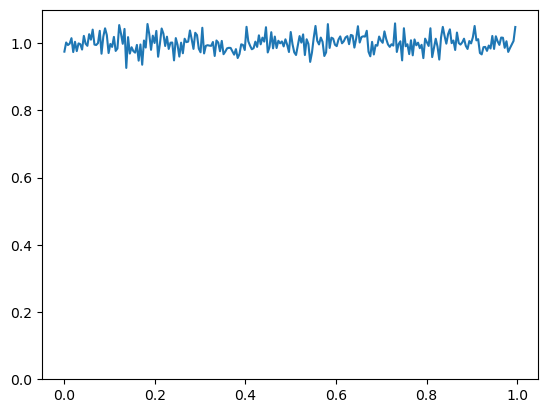

In [48]:
plt.plot(np.arange(0,1,1/(wfs_dist.shape[-1])),wfs_dist[0,0]*(wfs_dist.shape[-1]))
# plt.plot(x,wfs_dist[10,15])
plt.ylim(0,1.1)

In [23]:
x=np.linspace(0,1,dist.shape[0])


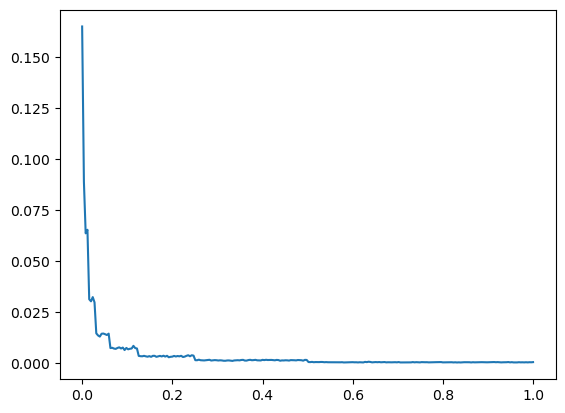

In [27]:
plt.plot(x,(dist))

In [55]:
dist2[256//3-2:256//3+3]

tensor([0.0232, 0.0499, 0.0878, 0.0370, 0.0301])

In [54]:
dist2[256//3*2-2:256//3*2+3]

tensor([0.0296, 0.0342, 0.0862, 0.0458, 0.0206])

In [52]:
dist2[256//3*2-1]

tensor(0.0342)

In [53]:
dist2[256//3*2+1]

tensor(0.0458)

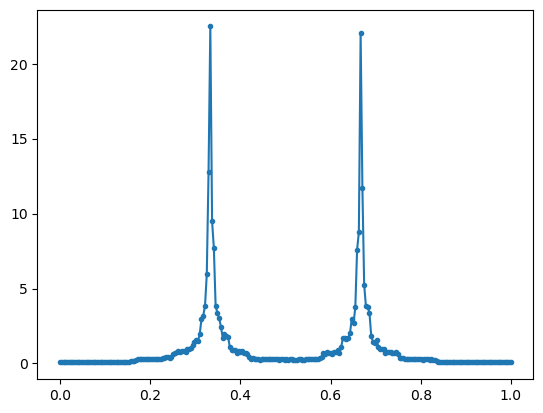

In [111]:
plt.plot(np.linspace(0,1,dist2.shape[0]),(dist2)*dist2.shape[0],'.-')
# plt.plot(np.linspace(0,1,dist3.shape[0]),(dist3)*dist3.shape[0],'-')
# plt.plot(np.linspace(0,1,dist4.shape[0]),(dist4)*dist4.shape[0],'-')
# plt.plot(np.linspace(0,1,dist5.shape[0]),(dist5)*dist5.shape[0],'-')
# plt.xlim([1/3-.005,1/3+.005])
# plt.yscale('log')

(0.3233333333333333, 0.3433333333333333)

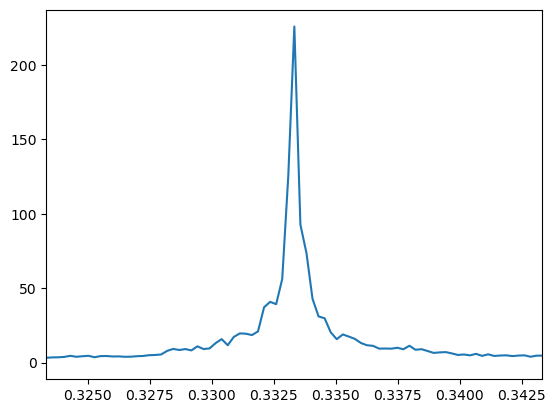

In [127]:
plt.plot(np.linspace(0,1,dist3.shape[0]),(dist3)*dist3.shape[0])
plt.xlim([1/3-.01,1/3+.01])

In [59]:
dist3[dist3.shape[0]//3]/dist3[dist3.shape[0]//3+1]

tensor(2.4384)

In [61]:
dist2[dist2.shape[0]//3]/dist2[dist2.shape[0]//3+1]

tensor(2.3711)

In [46]:
dist3[dist3.shape[0]//3]+dist3[dist3.shape[0]//3*2]

tensor(0.1021)

In [47]:
dist2[dist2.shape[0]//3]+dist2[dist2.shape[0]//3*2]

tensor(0.1740)

In [40]:
0b101010101010

2730

In [41]:
0b010101010101

1365

In [43]:
4096//3*2

2730

In [44]:
def generate_bitstring(n):
    l=np.arange(1<<n)
    bin_list=[bin(i)[2:].zfill(n) for i in l]
    bin_list=[[int(b) for b in i] for i in bin_list]

    return np.array(bin_list)

In [135]:
bitstring=generate_bitstring(12)

In [47]:
def ZZ(bitstring,k=2):
    n=bitstring.shape[1]
    J=k**np.arange(n-2,-1,-1)
    return np.sum(J*(2*bitstring[:,:-1]-1)*(2*bitstring[:,1:]-1),axis=1)

In [48]:
def Z(bitstring,k=2):
    n=bitstring.shape[1]
    J=k**np.arange(n-1,-1,-1)
    return np.sum(J*(2*bitstring-1),axis=1)

In [118]:
def Z_domain(bitstring,k=2):
    dw_pos=[]
    for bs in bitstring:
        pos=0
        while pos<bs.shape[0] and bs[pos]==0:
            pos+=1
        dw_pos.append(bs.shape[0]-pos)

    return np.array(dw_pos)

In [132]:
def ZZ_domain(bitstring,k=2):
    dw=(2*bitstring[:,:-1]-1)*(2*bitstring[:,1:]-1)
    dw_pos=[]
    for bs in dw:
        pos=0
        while pos<bs.shape[0] and bs[pos]==-1:
            pos+=1
        dw_pos.append(bs.shape[0]-pos)

    return np.array(dw_pos)

In [144]:
en=Z_domain(bitstring)

In [136]:
en=ZZ_domain(bitstring)

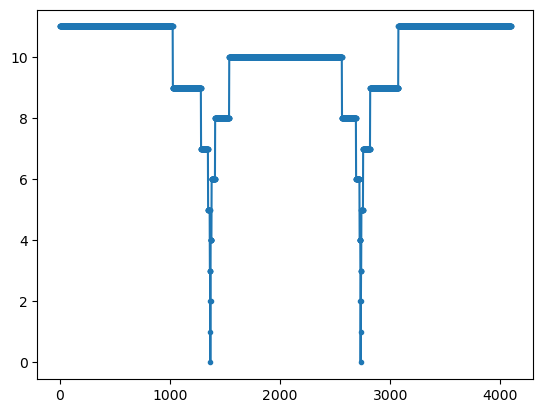

In [137]:
plt.plot(en,'.-')

In [113]:
bitstring

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [120]:
en

array([ 0,  1,  2, ..., 12, 12, 12])

In [62]:
en=ZZ(bitstring)

In [143]:
en=Z(bitstring)

In [103]:
dist2[170]

tensor(0.0862)

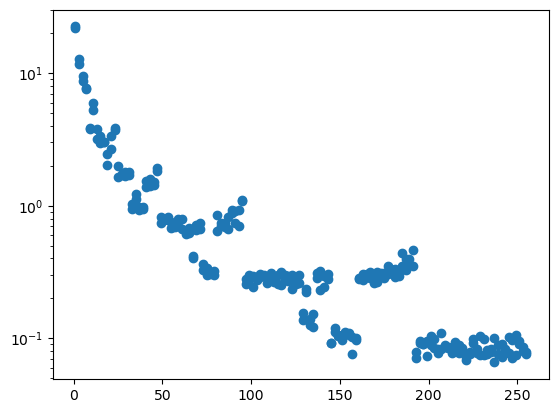

In [59]:
plt.scatter(en-en.min()+1,(wfs_1_3_8_dist[10,0])*wfs_1_3_8_dist[10,0].shape[0])
plt.yscale('log')
# plt.xscale('log')

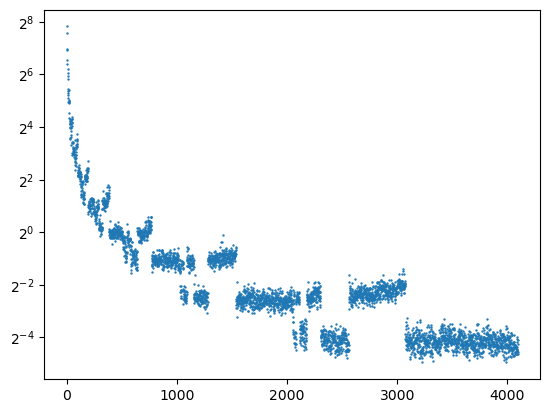

In [68]:
plt.scatter(en-en.min()+1,(wfs_1_3_12_dist[10,0])*wfs_1_3_12_dist[10,0].shape[0],s=0.5)
plt.yscale('log',base=2)
# plt.xscale('log')

In [161]:
import pandas as pd

In [176]:
df=pd.DataFrame({'en':en,'p':wfs_0_12_dist[10,0]*wfs_0_12_dist[10,0].shape[0]})
df_half=pd.DataFrame({'en':en,'p':wfs_0_12_dist_half[10,0]*wfs_0_12_dist_half[10,0].shape[0]})
df_quarter=pd.DataFrame({'en':en,'p':wfs_0_12_dist_quarter[10,0]*wfs_0_12_dist_quarter[10,0].shape[0]})

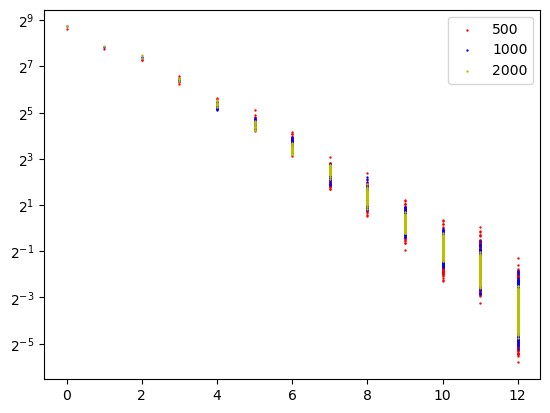

In [159]:
plt.scatter(en,(wfs_0_12_dist_quarter[10,0])*wfs_0_12_dist_quarter[10,0].shape[0],s=0.5,label='500',color='r')
plt.scatter(en,(wfs_0_12_dist_half[10,0])*wfs_0_12_dist_half[10,0].shape[0],s=0.5,label='1000',color='b')
plt.scatter(en,(wfs_0_12_dist[10,0])*wfs_0_12_dist[10,0].shape[0],s=0.5,label='2000',color='y')

plt.yscale('log',base=2)
# plt.xscale('log')
plt.legend()

,p
en,
0,422.283752
1,234.312225
2,172.685638
3,86.959503
4,41.756622
5,21.515642
6,10.576066
7,5.557803
8,2.533135


In [ ]:
plt.plot(df.groupby('en').mean())

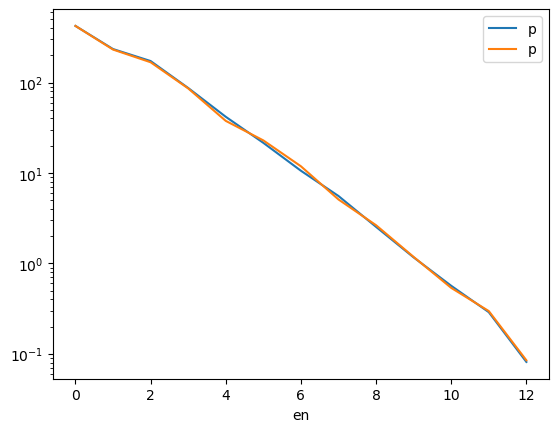

In [183]:
fig,ax=plt.subplots()
df.groupby('en').mean().plot(ax=ax,label='2000')
df_half.groupby('en').mean().plot(ax=ax,label='1000')

ax.legend()
ax.set_yscale('log')

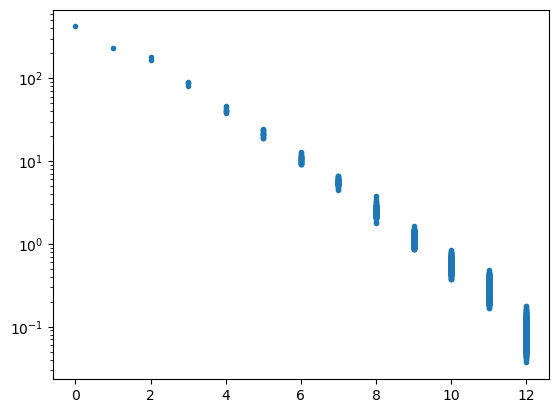

In [166]:
plt.plot(df['en'],df['p'],'.')
plt.yscale('log')

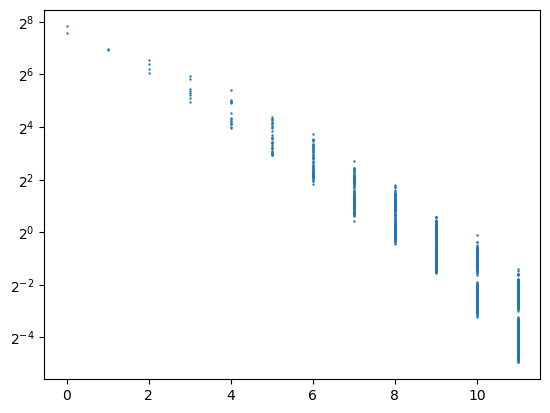

In [138]:
plt.scatter(en,(wfs_1_3_12_dist[10,0])*wfs_1_3_12_dist[10,0].shape[0],s=0.5)
plt.yscale('log',base=2)
# plt.xscale('log')

In [200]:
en=Z(bitstring,k=2)

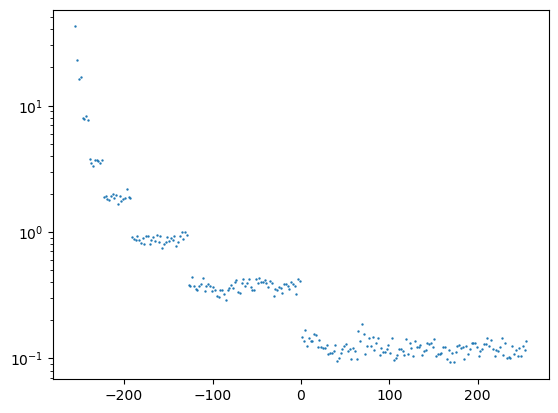

In [203]:
plt.scatter(en,(dist)*dist.shape[0],s=0.5)
plt.yscale('log')
# plt.xscale('log')

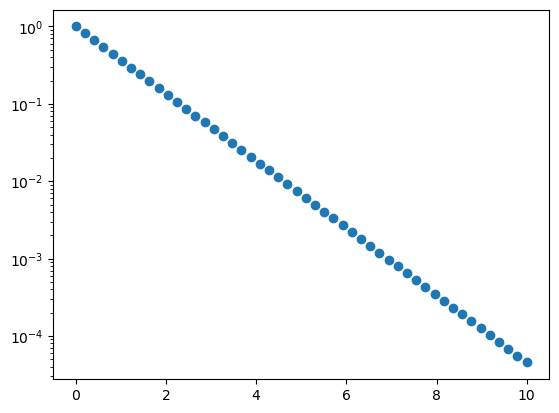

In [204]:
plt.scatter(np.linspace(0, 10),np.exp(-np.linspace(0, 10)**1))
plt.yscale(value='log')

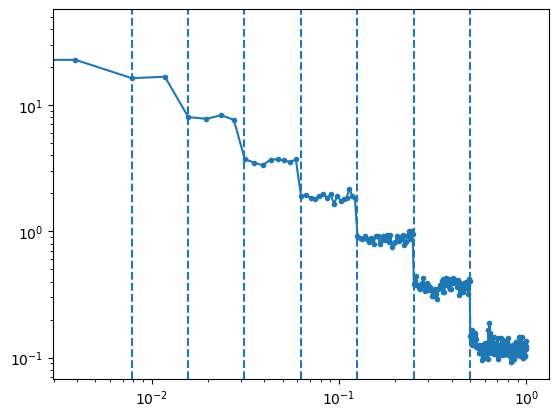

In [140]:
plt.plot(np.linspace(0,1,dist.shape[0]),(dist)*dist.shape[0],'.-')
plt.yscale('log')
plt.xscale('log')
for i in np.arange(1,8):
    plt.axvline(x=1/2**i,ls='dashed')

In [179]:
np.log2(wfs_0_12_dist.shape[-1])

12.0

# Distribution of xj=0

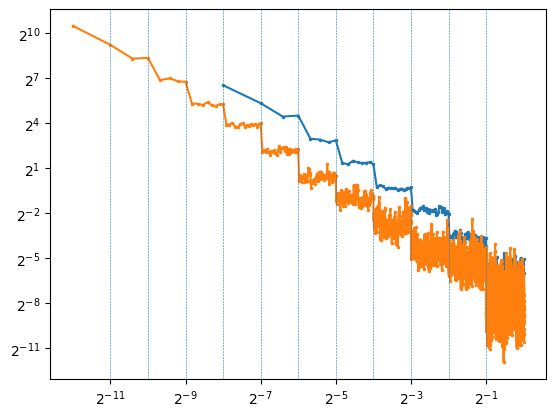

In [96]:
fig,ax=plt.subplots()

ax.plot(np.arange(0,1,1/wfs_0_8_dist[12,0].shape[0])+1/wfs_0_8_dist[12,0].shape[0],(wfs_0_8_dist[12,0])*wfs_0_8_dist[12,0].shape[0],'.-',markersize=3,label='L=8')

ax.plot(np.arange(0,1,1/wfs_0_10_dist[12,0].shape[0])+1/wfs_0_10_dist[12,0].shape[0],(wfs_0_10_dist[12,0])*wfs_0_10_dist[12,0].shape[0],'.-',markersize=3,label='L=8')

ax.plot(np.arange(0,1,1/wfs_0_12_dist[12,0].shape[0])+1/wfs_0_12_dist[12,0].shape[0],(wfs_0_12_dist[12,0])*wfs_0_12_dist[12,0].shape[0],'.-',markersize=3,label='L=12')

ax.set_yscale('log',base=2)
ax.set_xscale('log',base=2)
# ax.grid('on',axis='y')

for i in np.arange(1,12):
    ax.axvline(x=1/2**i,ls='dashed',lw=0.4,)

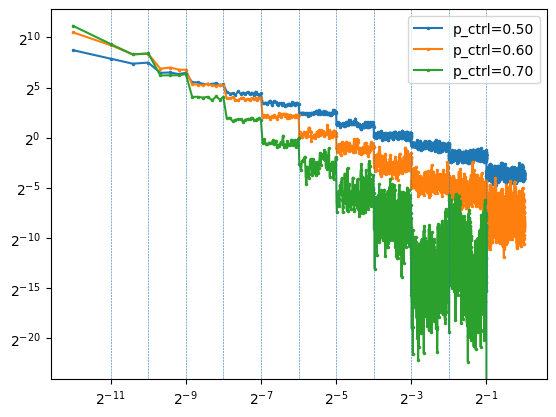

In [74]:
fig,ax=plt.subplots()
p_list=np.linspace(0,1,21)
for i in [10,12,14]:
    ax.plot(np.arange(0,1,1/wfs_0_12_dist[i,0].shape[0])+1/wfs_0_12_dist[i,0].shape[0],(wfs_0_12_dist[i,0])*wfs_0_12_dist[i,0].shape[0],'.-',markersize=3,label=f'p_ctrl={p_list[i]:.2f}')

ax.legend()
ax.set_yscale('log',base=2)
ax.set_xscale('log',base=2)
# ax.grid('on',axis='y')

for i in np.arange(1,12):
    ax.axvline(x=1/2**i,ls='dashed',lw=0.4,)

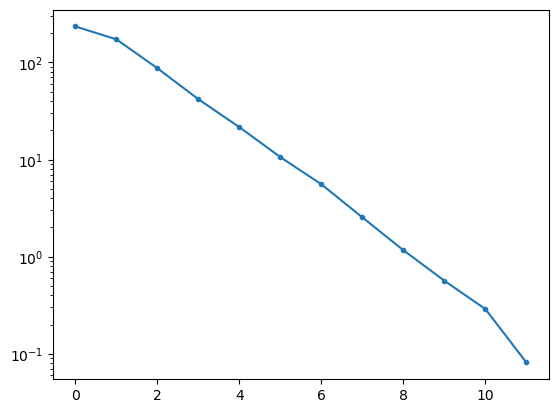

In [82]:
plt.plot([torch.mean(wfs_0_12_dist[10,0][2**i:2**(i+1)])*wfs_0_12_dist[10,0].shape[0] for i in range(12)],'.-')
plt.yscale('log')

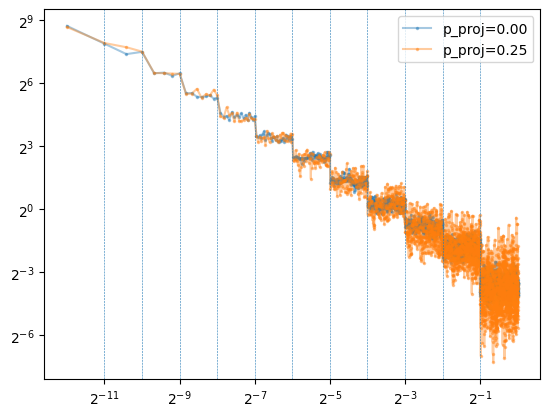

In [26]:
fig,ax=plt.subplots()
p_list=np.linspace(0,1,21)
for i in [0,5,]:
    ax.plot(np.arange(0,1,1/wfs_0_12_dist[10,i].shape[0])+1/wfs_0_12_dist[10,i].shape[0],(wfs_0_12_dist[10,i])*wfs_0_12_dist[10,i].shape[0],'.-',markersize=3,label=f'p_proj={p_list[i]:.2f}',alpha=0.4)

ax.legend()
ax.set_yscale('log',base=2)
ax.set_xscale('log',base=2)
# ax.grid('on',axis='y')

for i in np.arange(1,12):
    ax.axvline(x=1/2**i,ls='dashed',lw=0.4,)

# Distribution of xj={1/3,2/3}

In [27]:
wfs_1_3_8_dist[10,0].shape[0]

256

In [41]:
def generate_distance_1_3(wf):
    bitstring_1_3=np.arange(0,1,1/wf.shape[0])
    bitstring_1_3_distance=np.abs(np.r_[bitstring_1_3[:bitstring_1_3.shape[0]//2]-bitstring_1_3[bitstring_1_3.shape[0]//3],bitstring_1_3[bitstring_1_3.shape[0]//2:]-bitstring_1_3[bitstring_1_3.shape[0]//3*2]])
    return bitstring_1_3_distance

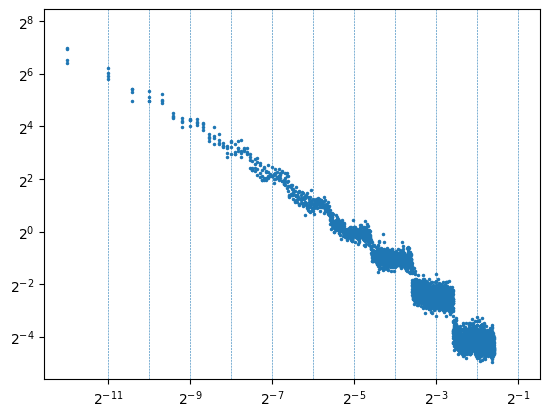

In [98]:
fig,ax=plt.subplots()
# ax.plot(generate_distance_1_3(wfs_1_3_8_dist[10,0]),(wfs_1_3_8_dist[10,0])*wfs_1_3_8_dist[10,0].shape[0],'.',markersize=3,label='L=8')
ax.plot(generate_distance_1_3(wfs_1_3_12_dist[10,0]),(wfs_1_3_12_dist[10,0])*wfs_1_3_12_dist[10,0].shape[0],'.',markersize=3,label='L=12')
# ax.plot(np.linspace(0,1,wfs_1_3_12_dist[12,0].shape[0])+1/wfs_1_3_12_dist[12,0].shape[0],(wfs_1_3_12_dist[12,0])*wfs_1_3_12_dist[12,0].shape[0],'.-',markersize=3,label='L=12')


ax.set_yscale('log',base=2)
ax.set_xscale('log',base=2)
# ax.grid('on',axis='y')

for i in np.arange(1,12):
    ax.axvline(x=1/2**i,ls='dashed',lw=0.4,)

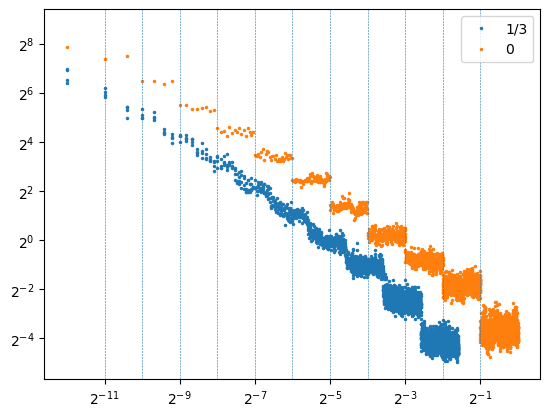

In [104]:
fig,ax=plt.subplots()
ax.plot(generate_distance_1_3(wfs_1_3_12_dist[10,0]),(wfs_1_3_12_dist[10,0])*wfs_1_3_12_dist[10,0].shape[0],'.',markersize=3,label='1/3')

ax.plot(np.arange(0,1,1/wfs_0_12_dist[10,0].shape[0]),(wfs_0_12_dist[10,0])*wfs_0_12_dist[10,0].shape[0],'.',markersize=3,label='0')



ax.set_yscale('log',base=2)
ax.set_xscale('log',base=2)
# ax.grid('on',axis='y')
ax.legend()

for i in np.arange(1,12):
    ax.axvline(x=1/2**i,ls='dashed',lw=0.4,)

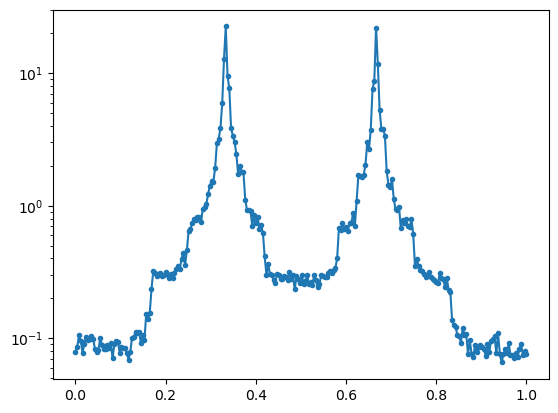

In [135]:
plt.plot(np.linspace(0,1,dist2.shape[0]),(dist2)*dist2.shape[0],'.-')
plt.yscale('log')

In [57]:
str(2<<1)

'4'

In [ ]:
check correlation , FWHM, fit lorentzian
peak,FWHM as a function of (p_ctrl, p_proj,)
what curve is best fit? Does not look like Lorenzian because it seems unbounded at the center, well could be just gaussian, where the sigma is infinitely small? lorentzian is also possible though. because both distributions have 1/lw at the center 
is there any hamiltonian describe this?

can we have a Heisenberg model where the J is like 2^n?